In [2]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('colorblind')

Replicating Wilcox et al's basic results before island constraints.

In [3]:
all_outputs = os.listdir("grammar_outputs/wilcox_replication")
basic_outputs = [output_file for output_file in all_outputs if "basic" in output_file]
basic_effects = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication", output_filename)))
    stim_id = 1
    # get model/construction (subj obj or pp) from filenames
    model_name = output_filename.split(".json")[0][-4:]
    construction_name = output_filename.split(".json")[0].split("_")[1]
    for stim_set in construction_data:
        basic_effects.append({
            "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "gap",
            "wh_effect": stim_set['s_ab']['critical_surprisal'] - stim_set['s_xb']['critical_surprisal']
        })
        basic_effects.append({
                        "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "nogap",
            "wh_effect": stim_set['s_ax']['critical_surprisal'] - stim_set['s_xx']['critical_surprisal']
        })
        stim_id +=1


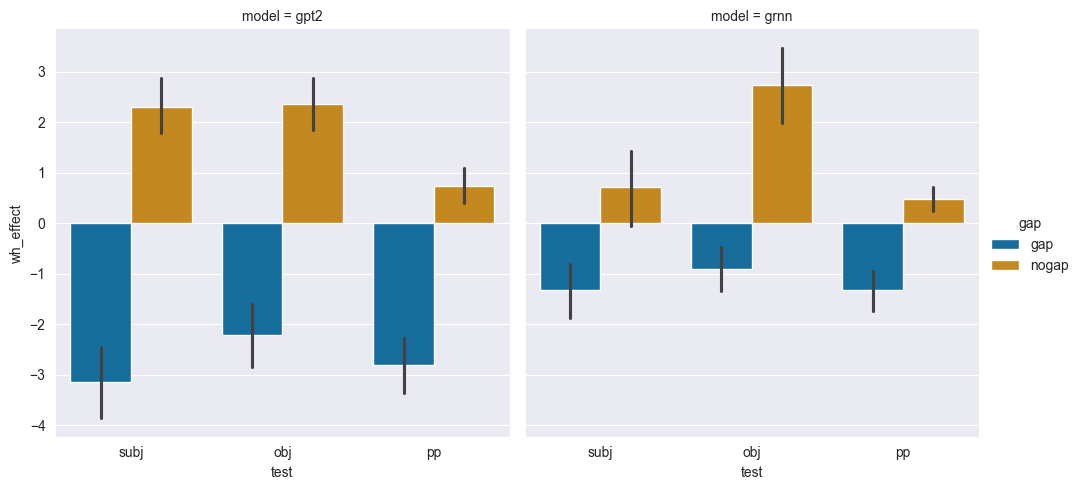

In [4]:
basic_effects = pd.DataFrame(basic_effects)
sns.catplot(x="test", y="wh_effect", hue="gap", data=basic_effects, kind="bar", col = "model",
            estimator="mean")
if "figures" not in os.listdir("."):
    os.mkdir("figures")
plt.savefig("figures/basic_fg.png")

Wilcox et al: run "Linear mixed-effects models on raw surprisal values with sum-coded conditions and by-item random slopes". We're looking for a significantly negative interaction term between the presence & absence of gaps.

In order to do this, we need to re-read the files for raw surprisal values and make features to put into our regression model (wh/that, gap/nogap)

In [5]:
def modify_base_dict(sentence_key, stim_set, base_dict):
    sent_copy = base_dict.copy()
    # replace 0 with -1 for island
    if sentence_key == "s_ab":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_xb":
        sent_copy['wh'] = -1
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_ax":
        sent_copy['wh'] = 1
        sent_copy['gap'] = -1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    else: # s_xx
        sent_copy['wh'] = -1
        sent_copy['gap'] = -1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    return sent_copy

In [6]:
basic_surprisals = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication",output_filename)))
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    for i in construction_data:
        model_name = output_filename.split(".json")[0][-4:]
        construction_name = output_filename.split(".json")[0].split("_")[1]
        for stim_set in construction_data:
            base_info = {
                "item": stim_id,
                "model": model_name,
                "test": construction_name
            }
            basic_surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
            stim_id +=1

In [7]:
basic_surprisals = pd.DataFrame(basic_surprisals)

We now fit mixed-effects models for each model & condition

In [8]:
from pymer4.models import Lmer

In [9]:
def fit_regression_model(lm, condition, surprisal_data, formula):
    condition_data = surprisal_data[(surprisal_data['model'] == lm) & (surprisal_data['test'] == condition)]
    model = Lmer(formula, data = condition_data)
    model.fit()
    return model.summary()

In [10]:
import itertools

In [11]:
conditions, models = basic_surprisals['test'].unique(), basic_surprisals['model'].unique()
interaction_results = []
basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"
for condition, model in itertools.product(conditions, models):
    print(condition , model)
    summary = fit_regression_model(model, condition, basic_surprisals, basic_formula)
    result = summary[['Estimate', 'P-val', 'Sig']].iloc[-1]
    result['model'] = model
    result['condition'] = condition
    interaction_results.append(result)


subj gpt2
Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -25968.787 	 AIC: 51953.574

Random effects:

                 Name     Var    Std
item      (Intercept)   7.845  2.801
item.1             wh   0.097  0.311
item.2            gap  10.290  3.208
Residual                2.683  1.638

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -25968.787 	 AIC: 51953.574

Random effects:

                 Name     Var    Std
item      (Intercept)   7.845  2.801
item.1             wh   0.097  0.311
item.2            gap  10.290  3.208
Residual                2.683  1.638

No random effect correlations specified

Fixed effects:

subj grnn
boun

We have a negative interaction term, and the result is statistically significant (really low p-values get rounded down to 0).

In [12]:
pd.DataFrame(interaction_results)

,Estimate,P-val,Sig,model,condition
wh:gap,-1.362,0.0,***,gpt2,subj
wh:gap,-0.509,0.0,***,grnn,subj
wh:gap,-1.145,0.0,***,gpt2,obj
wh:gap,-0.914,0.0,***,grnn,obj
wh:gap,-0.885,0.0,***,gpt2,pp
wh:gap,-0.448,0.0,***,grnn,pp


## Plotting the Island data

In [13]:
from generate_corpora import corpus_from_json
from analysis import island_effects_for_model
import pandas as pd
import seaborn as sns

In [14]:
grnn_control, grnn_island = corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_obj_grnn.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_that_grnn.json", is_tuples = True)
gptwiki_control, gptwiki_island = corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_obj_gpt2.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_that_gpt2.json", is_tuples = True)
grnn_cnp_island_effects = island_effects_for_model("grnn", grnn_control, grnn_island, "wh_mvt")
gpt2_cnp_island_effects = island_effects_for_model("gpt2", gptwiki_control, gptwiki_island, "wh_mvt")
island_effects = pd.DataFrame(grnn_cnp_island_effects + gpt2_cnp_island_effects)

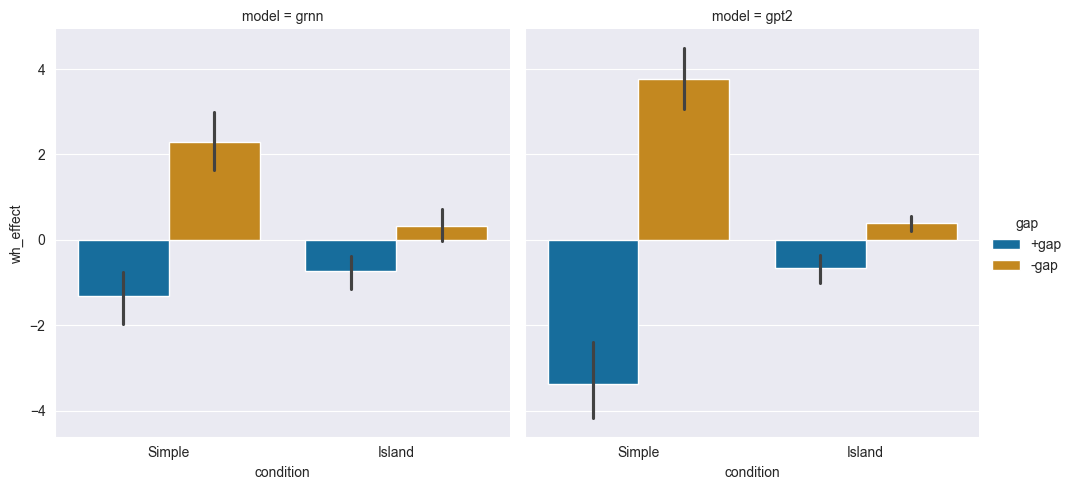

In [15]:
sns.catplot(x="condition", y="wh_effect", hue="gap", data=island_effects, kind="bar", col = "model",
            estimator="mean")
plt.savefig("figures/wilcox_cnp_island.png")

In [16]:
from analysis import * 

In [17]:
model = "gpt2"
control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)

def island_surprisals(condition_name, tuples, model_name):
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    surprisals = []
    for stim_set in tuples:
        stim_set = stim_set.to_dict()
        base_info = {
            "item": stim_id,
            "model": model_name,
            "island": 1 if condition_name == "island" else 0,
        }
        surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
        surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
        stim_id +=1
    return surprisals

In [18]:
all_island_surprisals = []
for model_name in ["gpt2", "grnn"]:
    control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
    island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)
    all_island_surprisals += island_surprisals("control", control_tuples, model_name)
    all_island_surprisals += island_surprisals("island", island_tuples, model_name)

In [19]:
all_island_surprisals = pd.DataFrame(all_island_surprisals)


### Basic Filler Gap Licensing

We first run the test on the simple items

In [20]:
simple_surprisals = all_island_surprisals[all_island_surprisals['island'] == 0]

basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"

summaries = []
for model_name in models:
    model_data = simple_surprisals[simple_surprisals['model'] == model_name]
    model = Lmer(basic_formula, data = model_data)
    model.fit()
    summary = model.summary()
    summary['model'] = model_name
    summaries.append(summary)
pd.concat(summaries)

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -284.197 	 AIC: 584.394

Random effects:

                 Name     Var    Std
item      (Intercept)  11.308  3.363
item.1             wh   0.000  0.000
item.2            gap   5.878  2.424
Residual                2.552  1.598

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -284.197 	 AIC: 584.394

Random effects:

                 Name     Var    Std
item      (Intercept)  11.308  3.363
item.1             wh   0.000  0.000
item.2            gap   5.878  2.424
Residual                2.552  1.598

No random effect correlations specified

Fixed 

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig,model
(Intercept),15.945,14.665,17.226,0.653,27.000,24.412,0.000,***,gpt2
wh,0.096,-0.200,0.392,0.151,54.000,0.636,0.527,,gpt2
gap,-0.436,-1.382,0.509,0.482,27.000,-0.904,0.374,,gpt2
wh:gap,-1.782,-2.078,-1.486,0.151,54.000,-11.807,0.000,***,gpt2
(Intercept),19.378,18.162,20.595,0.621,26.995,31.216,0.000,***,grnn
wh,0.244,0.010,0.477,0.119,54.002,2.044,0.046,*,grnn
gap,2.200,0.516,3.883,0.859,26.998,2.560,0.016,*,grnn
wh:gap,-0.905,-1.139,-0.672,0.119,54.002,-7.599,0.000,***,grnn


The three-way interaction term (filler x gap x island) is significant for both models. Wilcox et al code this as 0, 1 rather than -1, 1 with FGEs.

In [21]:
grnn_island = all_island_surprisals[all_island_surprisals['model'] == 'grnn']
grnn_island['gap'] = grnn_island['gap'].apply(recode_fg)
grnn_island['wh'] = grnn_island['wh'].apply(recode_fg)
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = grnn_island)
model.fit()
model.summary()

/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_16720/1670563139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grnn_island['gap'] = grnn_island['gap'].apply(recode_fg)
/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_16720/1670563139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grnn_island['wh'] = grnn_island['wh'].apply(recode_fg)


Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),16.030,13.767,18.293,1.155,31.625,13.881,0.000,***
wh,2.298,1.276,3.319,0.521,160.061,4.409,0.000,***
gap,6.210,3.057,9.363,1.609,31.786,3.861,0.001,***
island,-2.362,-3.384,-1.341,0.521,160.061,-4.532,0.000,***
wh:gap,-3.621,-5.066,-2.177,0.737,160.061,-4.913,0.000,***
wh:island,-1.976,-3.420,-0.531,0.737,160.061,-2.680,0.008,**
gap:island,2.226,0.782,3.671,0.737,160.061,3.020,0.003,**
wh:gap:island,2.563,0.520,4.606,1.042,160.061,2.459,0.015,*


## Testing for Gap Effects

Following Kobzeva et al (2023), we separately look for filled gap effects (-gap) and unlicensed gap (+gap) effects.
They fit the regression models to filler effects and code for islands the feature, rather than fitting the model on raw surprisal effects.

In [24]:
def code_island(value):
    if value == "Island":
        return -0.5
    else:
        return 0.5

island_effects['island'] = island_effects['condition'].apply(code_island)

In [25]:
grnn_effects = island_effects[island_effects['model'] == 'grnn']
gap_effects = grnn_effects[grnn_effects['gap'] == '+gap']
nogap_effects = grnn_effects[grnn_effects['gap'] == '-gap']
formula = "wh_effect ~ island + (1 + island || item)"
model = Lmer(formula, data = gap_effects)
model.fit()
model.summary()

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -97.975 	 AIC: 205.950

Random effects:

                 Name    Var    Std
item      (Intercept)  0.848  0.921
item.1         island  0.944  0.971
Residual               0.959  0.979

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -97.975 	 AIC: 205.950

Random effects:

                 Name    Var    Std
item      (Intercept)  0.848  0.921
item.1         island  0.944  0.971
Residual               0.959  0.979

No random 

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-1.030,-1.457,-0.603,0.218,27.0,-4.730,0.000,***
island,-0.587,-1.214,0.039,0.320,27.0,-1.838,0.077,.


In [26]:
model = Lmer(formula, data = nogap_effects)
model.fit()
model.summary()

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -100.982 	 AIC: 211.964

Random effects:

                 Name    Var    Std
item      (Intercept)  0.785  0.886
item.1         island  2.317  1.522
Residual               0.825  0.908

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -100.982 	 AIC: 211.964

Random effects:

                 Name    Var    Std
item      (Intercept)  0.785  0.886
item.1         island  2.317  1.522
Residual               0.825  0.908

No rando

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.310,0.905,1.715,0.207,27.0,6.336,0.0,***
island,1.976,1.238,2.713,0.376,27.0,5.250,0.0,***


We now try fitting models to both the presence of fillers and islands. 

In [27]:
def code_island(value):
    if value == 1:
        return -0.5
    else:
        return 0.5

def code_filler(value):
    if value == 1:
        return 0.5
    else:
        return -0.5

def reformat_for_gap(data):
    data['island'] = data['island'].apply(code_island)
    data['filler'] = data['wh'].apply(code_filler)
    return data
island_gap_surprisals = reformat_for_gap(all_island_surprisals)

Our method: filler and island

In [28]:
grnn = island_gap_surprisals[(island_gap_surprisals['model'] == 'grnn')]
gap = grnn[grnn['gap'] == 1]
no_gap = grnn[grnn['gap'] == 0]

In [33]:
formula = "surprisal ~ filler * island + (1 | item)"
model = Lmer(formula, data = gap)
model.fit()
gap_summary = model.summary()
gap_summary['gap'] = 1

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -278.086 	 AIC: 568.173

Random effects:

                 Name     Var    Std
item      (Intercept)  16.822  4.101
Residual                4.453  2.110

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -278.086 	 AIC: 568.173

Random effects:

                 Name     Var    Std
item      (Intercept)  16.822  4.101
Residual                4.453  2.110

No random effect correlations specified

Fixed effects:



In [34]:
formula = "surprisal ~ filler * island +(1 | item)"
model = Lmer(formula, data = no_gap)
model.fit()
nogap_summary = model.summary()
nogap_summary['gap'] = 0

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -272.820 	 AIC: 557.641

Random effects:

                 Name     Var    Std
item      (Intercept)  34.921  5.909
Residual                3.108  1.763

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -272.820 	 AIC: 557.641

Random effects:

                 Name     Var    Std
item      (Intercept)  34.921  5.909
Residual                3.108  1.763

No random effect correlations specified

Fixed effects:



In [39]:
wh_movement_effects = pd.concat([gap_summary, nogap_summary])
wh_movement_effects

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig,gap
(Intercept),21.657,20.088,23.226,0.800,27.0,27.060,0.000,***,1
filler,-1.030,-1.812,-0.248,0.399,81.0,-2.582,0.012,*,1
island,-0.158,-0.939,0.624,0.399,81.0,-0.395,0.694,,1
filler:island,-0.587,-2.151,0.976,0.798,81.0,-0.737,0.464,,1
(Intercept),15.504,13.291,17.717,1.129,27.0,13.731,0.000,***,0
filler,1.310,0.657,1.963,0.333,81.0,3.932,0.000,***,0
island,3.350,2.697,4.003,0.333,81.0,10.055,0.000,***,0
filler:island,1.976,0.670,3.282,0.666,81.0,2.965,0.004,**,0


In [42]:
def format_for_latex(df):
    df['gap'] = df['gap'].apply(format_gap)
    df['T-stat'] = df['T-stat'].map(str) + df['Sig']
    df = df[["index", 'Estimate', "SE", 'T-stat']]
    return df.to_latex(float_format="%.3f", index = False)

format_for_latex(wh_movement_effects.reset_index())

/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_95548/4071296941.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(float_format="%.3f", index = False)


'\\begin{tabular}{lrrl}\n\\toprule\n        index &  Estimate &    SE &    T-stat \\\\\n\\midrule\n  (Intercept) &    21.657 & 0.800 &  27.06*** \\\\\n       filler &    -1.030 & 0.399 &   -2.582* \\\\\n       island &    -0.158 & 0.399 &    -0.395 \\\\\nfiller:island &    -0.587 & 0.798 &    -0.737 \\\\\n  (Intercept) &    15.504 & 1.129 & 13.731*** \\\\\n       filler &     1.310 & 0.333 &  3.932*** \\\\\n       island &     3.350 & 0.333 & 10.055*** \\\\\nfiller:island &     1.976 & 0.666 &   2.965** \\\\\n\\bottomrule\n\\end{tabular}\n'